In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [2]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pyross
import time 

In [3]:
M  = 2                  # the population has two age groups
N  =  5e4           # and this is the total population

# correct params

beta  = 0.02         # infection rate
gIa   = 1./7            # recovery rate of asymptomatic infectives
gIs   = 1./7            # recovery rate of asymptomatic infectives
alpha = 0.2          # fraction of asymptomatic infectives
fsa   = 0.8          # the self-isolation parameter

# set the age structure
fi = np.array([0.25, 0.75])  # fraction of population in age age group
Ni = N*fi

# set the contact structure
C = np.array([[18., 9.], [3., 12.]])

# set up initial condition
Ia0 = np.array([10, 10])  # each age group has asymptomatic infectives
Is0 = np.array([10, 10])   # and also symptomatic infectives
R0  = np.array([0, 0])  # there are no recovered individuals initially
S0  = Ni - (Ia0 + Is0 + R0)

Tf = 100
Nf = Tf+1

def contactMatrix(t):
    return C

parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}

# use pyross stochastic to generate traj and save 
# sto_model = pyross.stochastic.SIR(parameters, M, Ni)
# data = sto_model.simulate(S0, Ia0, Is0, contactMatrix, Tf, Nf)
# data_array = data['X']
# np.save('latent_SIR_traj.npy', data_array)

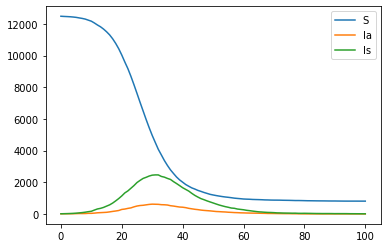

In [4]:
plt.plot(data_array[:, 0], label='S')
plt.plot(data_array[:, M], label='Ia')
plt.plot(data_array[:, 2*M], label='Is')
plt.legend()
plt.show()

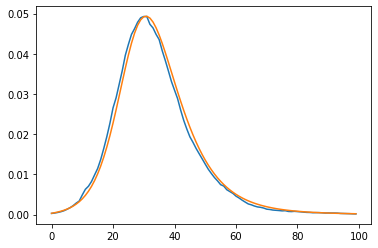

In [11]:
# load the data and rescale to intensive variables 
Tf = 100 # can truncate later 
Nf = Tf+1

x = np.load('latent_SIR_traj.npy').astype('float')
x = (x/N)[:Nf]
steps = 101 # number internal integration steps taken, must be an odd number 


# initialise the estimator 
estimator = pyross.inference.SIR(parameters, M, fi, int(N), steps)

fltr=np.repeat(np.array([False, False, True]), 2)
obs=x[:, fltr] # need to full obs for inference, don't change here 
x0=x[0]

# estimate mean and cov 
det_model = pyross.deterministic.SIR(parameters, int(M), fi)
xm,full_cov = estimator.obtain_full_mean_cov(x[0,:], Tf, Nf, det_model, contactMatrix)
plt.plot(x[1:,2*M])
plt.plot(xm[:,2*M])
plt.show()
# for i in range(6):
#     plt.imshow(full_cov[i::6,i::6])
#     plt.show()

In [12]:
# compute -log_p for the original (correct) parameters 
start_time = time.time() 
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
logp = estimator.minus_logp_red(parameters, x0, obs[1:], fltr, Tf, Nf, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

-1438.3485781147833
0.813870906829834


In [23]:
# make parameter guesses and set up bounds for each parameter 
eps = 1e-4 # step used to calculate hessian in the optimisation algorithm 
alpha_g = 0.2
alpha_std = 0.1 
alpha_bounds = (eps, 1-2*eps)
# the bound for alpha must be 1-2*eps to avoid alpha>1 in hessian calculation performed by optimizer 

beta_g = 0.04
beta_std = 0.05 
beta_bounds = (eps, 1)

gIa_g = 0.145
gIa_std = 0.1 
gIa_bounds = (eps, 1)

gIs_g = 0.145
gIs_std = 0.1 
gIs_bounds = (eps, 1) 

fsa_g = 0.8

Ia0_g = Ia0/N
Ia_std = Ia0_g*0.4 
bounds_for_Ia = np.tile([0.1/N, 100/N], M).reshape(M, 2)


Is0_g = Is0/N 
Is_std = Is0_g*0.2 
bounds_for_Is = np.tile([0.1/N, 100/N], M).reshape(M, 2)

S0_g = S0/N
S_std = Ia_std*np.sqrt(3)
bounds_for_S = np.tile([0.1/N, 1], M).reshape(M, 2)

# optimisation parameters 
ftol = 1e-5 # the relative tol in (-logp)  

# # set up bounds for the rest of the params 
# # the bound for alpha must be 1-2*eps to avoid alpha>1 in hessian calculation performed by optimizer 
bounds = np.array([alpha_bounds, beta_bounds, gIa_bounds, gIs_bounds, 
                   *bounds_for_S, *bounds_for_Ia, *bounds_for_Is])
guess = np.array([alpha_g, beta_g, gIa_g, gIs_g, *S0_g, *Ia0_g, *Is0_g])
stds = np.array([alpha_std, beta_std, gIa_std, gIs_std, *S_std, *Ia_std, *Is_std])
start_time = time.time()
params = estimator.latent_inference(guess, stds, obs, fltr, Tf, Nf, contactMatrix, bounds, 
                                    global_max_iter=15, global_ftol_factor=1e3, 
                                    verbose=True, ftol=ftol, eps=eps) 
end_time = time.time()
print(end_time - start_time)

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 10 (seed=341048, Thu Apr 30 20:22:39 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 -1.449747133227487e+03 1.0e+00 1.08e+00  1e-05  4e-02 0:06.0
    2     32 -1.332786777162723e+03 1.3e+00 1.14e+00  1e-05  4e-02 0:12.7
    3     48 -1.201854160364317e+03 1.2e+00 1.15e+00  2e-05  4e-02 0:19.9
    4     64 -1.061949666996061e+03 1.4e+00 1.06e+00  1e-05  4e-02 0:26.4
    5     80 -1.423383049493905e+03 1.5e+00 1.04e+00  1e-05  4e-02 0:33.4
    6     96 -1.474533055334180e+03 1.5e+00 1.06e+00  1e-05  4e-02 0:40.2
    7    112 -1.419629342762160e+03 1.6e+00 9.72e-01  1e-05  4e-02 0:46.5
    9    144 -1.288462133003385e+03 1.7e+00 8.50e-01  1e-05  3e-02 0:58.4
   11    176 -1.474785565830536e+03 1.9e+00 7.22e-01  8e-06  3e-02 1:10.6
   13    208 -1.466985646923819e+03 2.2e+00 7.20e-01  8e-06  3e-02 1:23.3
   15    240 -1.482587600644349e+03 2.4e+00 6.04e-01  7e-06  2e-

In [24]:
# save the parameters 
np.save('SIR_latent_param.npy', params)

{'alpha': 0.1726461495874574, 'beta': 0.020130226867684908, 'gIa': 0.12024615891942374, 'gIs': 0.1472697387329405, 'fsa': 0.8}


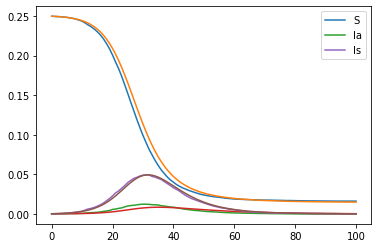

In [25]:
params = np.load('SIR_latent_param.npy')
parameters = {'alpha':params[0], 'beta':params[1], 'gIa':params[2], 'gIs':params[3],'fsa':0.8}
print(parameters)
estimator.set_params(parameters)
x0 = params[4:]
x_det = estimator.integrate(x0, 0, Tf, Nf, det_model, contactMatrix)
x = np.load('latent_SIR_traj.npy').astype('float')/N 
plt.plot(x[:,0], label='S')
plt.plot(x_det[:, 0])
plt.plot(x[:,1*M], label='Ia')
plt.plot(x_det[:, 1*M])
plt.plot(x[:,2*M], label='Is')
plt.plot(x_det[:, 2*M])
plt.legend()
plt.show()

guessed initial conditons:  [12480 37479    10    10    10     9]
true initial conditions:  [12480. 37480.] [10 10] [10 10]


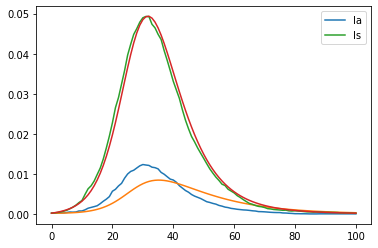

In [26]:
# replot the infected 
print('guessed initial conditons: ', (params[4:]*N).astype('int'))
print('true initial conditions: ', S0, Ia0, Is0)
plt.plot(x[:,1*M], label='Ia')
plt.plot(x_det[:, 1*M])
plt.plot(x[:,2*M], label='Is')
plt.plot(x_det[:, 2*M])
plt.legend()
plt.show()

## Guess with part of the trajectory  

In [4]:
# Cut the observed data 
Tf_small = 20 
Nf_small = Tf_small+1 
steps = 21


x = np.load('latent_SIR_traj.npy').astype('float')/N 
fltr=np.repeat(np.array([False, False, True]), 2)
obs=x[:Nf_small, fltr] # need to full obs for inference, don't change here 
x0 = x[0]

start_time = time.time() 
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
estimator = pyross.inference.SIR(parameters, M, fi, int(N), steps)
logp = estimator.minus_logp_red(parameters, x0, obs[1:], fltr, Tf_small, Nf_small, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

-284.4631800683397
0.1596517562866211


In [5]:
# make parameter guesses and set up bounds for each parameter 
eps = 1e-4 # step used to calculate hessian in the optimisation algorithm 
alpha_g = 0.2
alpha_std = 0.1 
alpha_bounds = (eps, 1-2*eps)
# the bound for alpha must be 1-2*eps to avoid alpha>1 in hessian calculation performed by optimizer 

beta_g = 0.04
beta_std = 0.05 
beta_bounds = (eps, 1)

gIa_g = 0.145
gIa_std = 0.1 
gIa_bounds = (eps, 1)

gIs_g = 0.145
gIs_std = 0.1 
gIs_bounds = (eps, 1) 

fsa_g = 0.8

Ia0_g = Ia0/N
Ia_std = Ia0_g*0.2 
bounds_for_Ia = np.tile([0.1/N, 100/N], M).reshape(M, 2)


Is0_g = Is0/N 
Is_std = Is0_g*0.1 
bounds_for_Is = np.tile([0.1/N, 100/N], M).reshape(M, 2)

S0_g = S0/N
S_std = Ia_std*np.sqrt(3)
bounds_for_S = np.tile([0.1/N, 1], M).reshape(M, 2)

# optimisation parameters 
ftol = 1e-5 # the relative tol in (-logp)  

# # set up bounds for the rest of the params 
# # the bound for alpha must be 1-2*eps to avoid alpha>1 in hessian calculation performed by optimizer 
bounds = np.array([alpha_bounds, beta_bounds, gIa_bounds, gIs_bounds, 
                   *bounds_for_S, *bounds_for_Ia, *bounds_for_Is])
guess = np.array([alpha_g, beta_g, gIa_g, gIs_g, *S0_g, *Ia0_g, *Is0_g])
stds = np.array([alpha_std, beta_std, gIa_std, gIs_std, *S_std, *Ia_std, *Is_std])

ftol=1e-5
start_time = time.time()
params = estimator.latent_inference(guess, stds, obs, fltr, Tf_small, Nf_small, contactMatrix, bounds, 
                                    global_max_iter=20, global_ftol_factor=1e3, 
                                    verbose=True, ftol=ftol, eps=eps) 
end_time = time.time()
print(end_time - start_time)

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 10 (seed=306018, Thu Apr 30 20:10:24 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 -3.169922880593834e+02 1.0e+00 9.94e-01  7e-06  3e-02 0:02.0
    2     32 -3.454733019219277e+02 1.3e+00 1.04e+00  7e-06  4e-02 0:03.3
    3     48 -3.452730084775375e+02 1.4e+00 1.15e+00  8e-06  4e-02 0:04.5
    6     96 -3.401432204850649e+02 1.8e+00 1.27e+00  9e-06  5e-02 0:07.7
   10    160 -3.474102272231871e+02 2.7e+00 1.21e+00  9e-06  5e-02 0:12.2
   14    224 -3.485072635951567e+02 3.4e+00 1.19e+00  9e-06  4e-02 0:17.4
   20    320 -3.449116908822186e+02 5.1e+00 8.13e-01  6e-06  3e-02 0:23.9
Optimal value (global minimisation):  -349.06639587857023
Starting local minimisation...
Optimal value (local minimisation):  -349.2227064583755
32.51787185668945


best estimates:  [0.08621869 0.0206067  0.06515577 0.16374209]


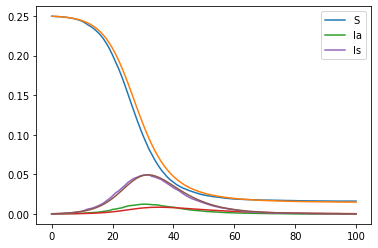

In [6]:
print('best estimates: ', params[:4])
parameters = estimator.make_params_dict(params[:4])
estimator.set_params(parameters)
x0 = params[4:]
det_model = pyross.deterministic.SIR(parameters, int(M), fi)
x_det = estimator.integrate(x0, 0, 100,101, det_model, contactMatrix)
x = np.load('latent_SIR_traj.npy').astype('float')
x = (x/N)
plt.plot(x[:,0], label='S')
plt.plot(x_det[:, 0])
plt.plot(x[:,1*M], label='Ia')
plt.plot(x_det[:, 1*M])
plt.plot(x[:,2*M], label='Is')
plt.plot(x_det[:, 2*M])
plt.legend()
plt.show()

When only the first 20 points are used, the whole trajectory is still well predicted 

In [7]:
hess1, hess2 = estimator.hessian_latent(params, guess, stds, obs[1:], fltr, Tf_small, Nf_small, contactMatrix)
cov1 = np.linalg.inv(hess1) 
cov2 = np.linalg.inv(hess2)

In [10]:
# throws an exception is not positive definite 
np.linalg.cholesky(cov1)
np.linalg.cholesky(cov2)

array([[ 6.92846542e-06,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 8.13043756e-16,  6.92823072e-06,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.11716487e-10, -1.39332648e-11,  4.19783323e-06,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-2.29082358e-11, -1.84531762e-11, -6.94741256e-09,
         4.18136210e-06,  0.00000000e+00,  0.00000000e+00],
       [-1.04444860e-11, -1.15612389e-12, -1.99214029e-09,
        -7.63691596e-10,  2.10121716e-06,  0.00000000e+00],
       [-2.26662786e-12, -3.47119032e-12, -1.66681916e-09,
        -1.85642932e-09, -4.58736806e-10,  2.09657688e-06]])